In [1]:
""" Importing the required libraries and tools """
%matplotlib inline
import tensorflow as tf
import numpy as np  # For working with arrays
from tqdm import tqdm  # Provides pretty graphics when loading data
import matplotlib.pyplot as plt  # For plotting figures
import cv2  # Open-cv for working with images
from IPython.display import clear_output  # Again, for pretty graphics
import os  # For reading files from disk
from random import shuffle, randrange  # For shuffling the data so our model becomes robust, hopefully
import pandas as pd  # For manipulating CSV files
import urllib.request  # For downloading files from the provided links
import time  # Yes, pretty graphics again
from termcolor import colored  # I LOVE COLOURED THINGS

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # For ignoring annoying tensorflow warnings



/home/vipin/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

""" Defining some required variables """
test_dir = 'Test'
train_dir = 'Train Data'
train_processed = 'Train Processed'
test_processed = 'Test Processed'


batch_size = 125
num_channels = 3
lr = 1e-4
img_size = 256
img_shape = (256, 256)

In [3]:
traincsv = pd.read_csv('myntra_train_dataset.csv')
testcsv = pd.read_csv('myntra_test.csv')

In [4]:
sub_category = []
for i in range(traincsv.shape[0]):
    if sub_category.__contains__(str(traincsv.iloc[i]['Sub_category'])):
        pass
    else:
        sub_category.append(str(traincsv.iloc[i]['Sub_category']))
print(len(sub_category), ' sub categories in the given test set are:\n', sub_category) 

24  sub categories in the given test set are:
 ['Graphic', 'Biker', 'Striped', 'Colourblocked', 'Tie and Dye', 'Solid', 'Typography', 'Geometric', 'Camouflage', 'Abstract', 'Tribal', 'People and Places', 'Conversational', 'Sports', 'Floral', 'Humour and Comic', 'Music', 'Checked', 'Self Design', 'Varsity', 'Sports and Team Jersey', 'Polka Dots', 'Superhero', 'Horizontal Stripes']


In [5]:
""" Some neural net related variables """


n_classes = len(sub_category)
x = tf.placeholder('float', [None, img_size, img_size, num_channels])  # Will hold the images
y = tf.placeholder('float',[None, n_classes])  # Will hold the labels

initializer = tf.contrib.layers.xavier_initializer()

In [6]:
""" CNN0 Parameters """


weights0 = {'W_conv1': tf.Variable(initializer([5, 5, 3, 16])),
               'W_conv2': tf.Variable(initializer([5, 5, 16, 32])),
               'W_conv3': tf.Variable(initializer([5, 5, 32, 32])),
               'W_conv4': tf.Variable(initializer([5, 5, 32, 32])),
               'W_fc1': tf.Variable(initializer([16*16*32, 1024])),
               'W_fc2': tf.Variable(initializer([1024, 512])),
               'W_fc3': tf.Variable(initializer([512, 128])),
               'out': tf.Variable(initializer([128, n_classes]))}
    
    
biases0 = {'b_conv1': tf.Variable(tf.random_normal([16])),
               'b_conv2': tf.Variable(tf.random_normal([32])),
               'b_conv3': tf.Variable(tf.random_normal([32])),
               'b_conv4': tf.Variable(tf.random_normal([32])),
               'b_fc1': tf.Variable(tf.random_normal([1024])),
               'b_fc2': tf.Variable(tf.random_normal([512])),
               'b_fc3': tf.Variable(tf.random_normal([128])),
               'out': tf.Variable(tf.random_normal([n_classes]))}

In [7]:
""" Here we will design our convolutional neural network by using the layers provided in 
    tf.layers"""


def CNN0(x):

    
    
    """ The image will be feeded to input layer """
    x = tf.image.convert_image_dtype(x, dtype=tf.float32)
    
    input_layer = tf.reshape(x, [-1, img_size, img_size, num_channels])
    
    
    """ First convolutional layer with 64 filters of 256x256 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(input_layer, weights0['W_conv1'], strides=[1, 1, 1, 1], padding='SAME', 
                                           name='conv1'), biases0['b_conv1']))
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Second convolutional layer with 128 filters of 128x128 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(pool1, weights0['W_conv2'], strides=[1, 1, 1, 1], padding='SAME', 
                                          name='conv2'), biases0['b_conv2']))
    
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Third convolutional layer with 128 filters of 64x64 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(pool2, weights0['W_conv3'], strides=[1, 1, 1, 1], padding='SAME', 
                                          name='conv3'), biases0['b_conv3']))
    
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Fourth convolutional layer with 64 filters of 32x32 dimentions, followed by replu & 2x2 maxpool layer """
    
    conv4 = tf.nn.relu(tf.add(tf.nn.conv2d(pool3, weights0['W_conv4'], strides=[1, 1, 1, 1], padding='SAME', 
                                      name='conv4'), biases0['b_conv4']))
    
    pool4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    dropout = tf.nn.dropout(pool4, keep_prob=0.6)
    
    """ A fully connected layers """
    
    fully_connected = tf.reshape(dropout, [-1, 16*16*32]) # This will work as flattening layer
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights0['W_fc1']), biases0['b_fc1'])) 
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights0['W_fc2']), biases0['b_fc2']))
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights0['W_fc3']), biases0['b_fc3']))
    
    """ Dropout layer to prevent over-fitting """
    dropout = tf.nn.dropout(fully_connected, keep_prob=0.6)
    
    
    """ Output Layer """
    
    out = tf.add(tf.matmul(dropout, weights0['out']), biases0['out']) # This is also know as logits layer
    return out

In [8]:
def load_batch(i):
    os.rename(train_processed+'/batch'+str(i+1)+'.npy', 'batch'+str(i+1)+'.npy')
    batch = np.load('batch'+str(i+1)+'.npy')
    x = np.array([j[0] for j in batch]).reshape(-1, img_size, img_size, num_channels)
    y = [j[1] for j in batch]
    os.rename('batch'+str(i+1)+'.npy', train_processed+'/batch'+str(i+1)+'.npy')
    return x, y

In [9]:
CNN_0 = []

In [10]:
saver = tf.train.Saver()

with tf.Session() as sess:
    
    acc0 = 0
    
    saver.restore(sess, 'tmp/Model0/model.ckpt')
    
    pred0 = CNN0(x)
    
    y_pred_cls0 = tf.argmax(tf.nn.softmax(pred0), 1)
    y_true_cls0 = tf.argmax(y, 1)
    correct0 = tf.equal(y_pred_cls0, y_true_cls0)  # 1 represents the axis
    accuracy = tf.reduce_mean(tf.cast(correct0, 'float32'))
    
    
    
    for i in range(640, 643):
        x_test, y_test = load_batch(i)
        acc0 += accuracy.eval({x: x_test, y: y_test})
        CNN_0.append((pred0.eval({x: x_test, y: y_test})))
    acc0 = acc0/3    
    
    print('Model 0 accuracy: ', acc0)

Model 0 accuracy:  0.8655913869539896


In [11]:
tf.reset_default_graph()

In [12]:
""" Some neural net related variables """


n_classes = len(sub_category)
x = tf.placeholder('float', [None, img_size, img_size, num_channels])  # Will hold the images
y = tf.placeholder('float',[None, n_classes])  # Will hold the labels

initializer = tf.contrib.layers.xavier_initializer()

In [13]:
""" CNN1 Parameters """


weights1 = {'W_conv1': tf.Variable(initializer([5, 5, 3, 16])),
               'W_conv2': tf.Variable(initializer([5, 5, 16, 32])),
               'W_conv3': tf.Variable(initializer([5, 5, 32, 64])),
               'W_conv4': tf.Variable(initializer([5, 5, 64, 32])),
               'W_fc1': tf.Variable(initializer([16*16*32, 1024])),
               'W_fc2': tf.Variable(initializer([1024, 512])),
               'W_fc3': tf.Variable(initializer([512, 128])),
               'out': tf.Variable(initializer([128, n_classes]))}
    
    
biases1 = {'b_conv1': tf.Variable(tf.random_normal([16])),
               'b_conv2': tf.Variable(tf.random_normal([32])),
               'b_conv3': tf.Variable(tf.random_normal([64])),
               'b_conv4': tf.Variable(tf.random_normal([32])),
               'b_fc1': tf.Variable(tf.random_normal([1024])),
               'b_fc2': tf.Variable(tf.random_normal([512])),
               'b_fc3': tf.Variable(tf.random_normal([128])),
               'out': tf.Variable(tf.random_normal([n_classes]))}

In [14]:
""" Here we will design our convolutional neural network by using the layers provided in 
    tf.layers"""

def CNN1(x):

    
    
    """ The image will be feeded to input layer """
    x = tf.image.convert_image_dtype(x, dtype=tf.float32)
    
    input_layer = tf.reshape(x, [-1, img_size, img_size, num_channels])
    
    
    """ First convolutional layer with 64 filters of 256x256 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(input_layer, weights1['W_conv1'], strides=[1, 1, 1, 1], padding='SAME', 
                                           name='conv1'), biases1['b_conv1']))
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Second convolutional layer with 128 filters of 128x128 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(pool1, weights1['W_conv2'], strides=[1, 1, 1, 1], padding='SAME', 
                                          name='conv2'), biases1['b_conv2']))
    
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Third convolutional layer with 128 filters of 64x64 dimentions, followed by relu & 2x2 maxpool layer """
    
    conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(pool2, weights1['W_conv3'], strides=[1, 1, 1, 1], padding='SAME', 
                                          name='conv3'), biases1['b_conv3']))
    
    pool3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    """ Fourth convolutional layer with 64 filters of 32x32 dimentions, followed by replu & 2x2 maxpool layer """
    
    conv4 = tf.nn.relu(tf.add(tf.nn.conv2d(pool3, weights1['W_conv4'], strides=[1, 1, 1, 1], padding='SAME', 
                                      name='conv4'), biases1['b_conv4']))
    
    pool4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    dropout = tf.nn.dropout(pool4, keep_prob=0.4)
    
    """ A fully connected layers """
    
    fully_connected = tf.reshape(dropout, [-1, 16*16*32]) # This will work as flattening layer
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights1['W_fc1']), biases1['b_fc1'])) 
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights1['W_fc2']), biases1['b_fc2']))
    fully_connected = tf.nn.relu(tf.add(tf.matmul(fully_connected, weights1['W_fc3']), biases1['b_fc3']))
    
    """ Dropout layer to prevent over-fitting """
    dropout = tf.nn.dropout(fully_connected, keep_prob=0.6)
    
    
    """ Output Layer """
    
    out = tf.add(tf.matmul(dropout, weights1['out']), biases1['out']) # This is also know as logits layer
    return out

In [15]:
CNN_1 = []

In [16]:
saver = tf.train.Saver()

with tf.Session() as sess:
    
    acc1 = 0
    
    saver.restore(sess, 'tmp/Model1/model1.ckpt')
    
    pred1 = CNN1(x)
    
    y_pred_cls1 = tf.argmax(tf.nn.softmax(pred1), 1)
    y_true_cls1 = tf.argmax(y, 1)
    correct1 = tf.equal(y_pred_cls1, y_true_cls1)  # 1 represents the axis
    accuracy = tf.reduce_mean(tf.cast(correct1, 'float32'))
    
    
    
    for i in range(640, 643):
        x_test, y_test = load_batch(i)
        acc1 += accuracy.eval({x: x_test, y: y_test})
        CNN_1.append(pred1.eval({x: x_test, y: y_test}))
    acc1 = acc1/3    
    
    print('Model 1 accuracy: ', acc1)

Model 1 accuracy:  0.7983870903650919


In [17]:
tf.reset_default_graph()

In [18]:
with tf.Session() as sess:
    ensemble = []
    CNN_0 = np.asarray(CNN_0)
    CNN_1 = np.asarray(CNN_1)
    ensemble = np.add(CNN_0, CNN_1)
    ensemble = np.divide(ensemble, 2.0)
    ensemble = tf.cast(ensemble, tf.float32)
    ensemble = tf.nn.softmax(ensemble)
    ensemble = ensemble.eval()
    ensemble = np.argmax(ensemble, 2)
    

    ans=0
    for i in range(640, 643):
        accu = []
        x_test, y_test = load_batch(i)
        z = i-640
        for j in range(124):
            accu.append(np.equal(ensemble[z][j], np.argmax(y_test[j], axis=0)))
        ac = np.asarray(accu)
        ac = ac.astype('float')
        ac = np.mean(ac)
        ans+=ac
    ans = ans/3
    print('Ensemble accuracy:', ans)
    

Ensemble accuracy: 0.9112903225806451


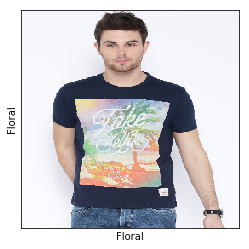

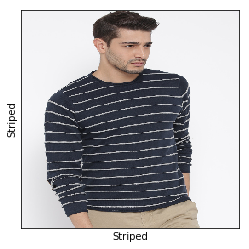

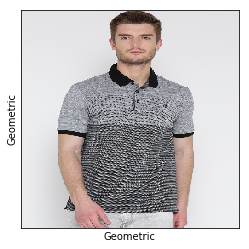

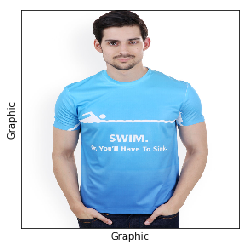

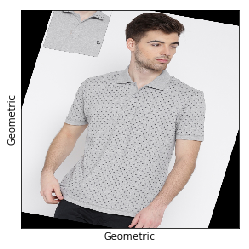

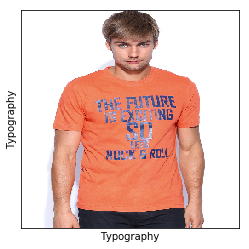

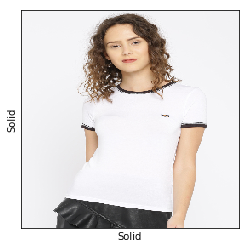

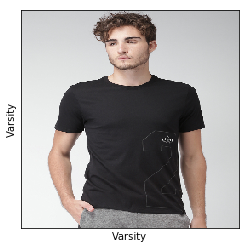

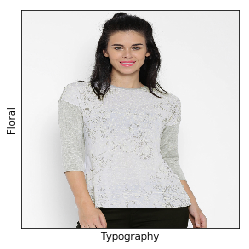

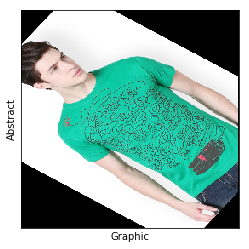

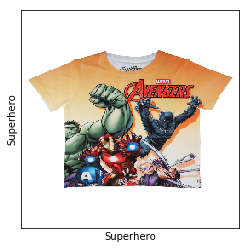

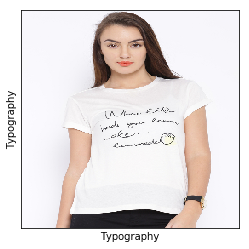

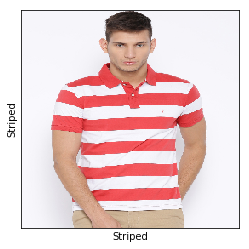

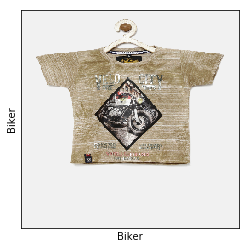

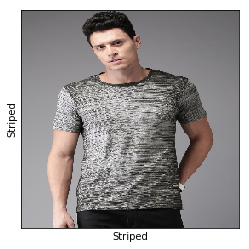

In [19]:
for i in range(640, 643):
        x_test, y_test = load_batch(i)
        z = i-640
        for k in range(5):
            j = randrange(0, 124)
            plt.imshow(cv2.cvtColor(x_test[j], cv2.COLOR_BGR2RGB))
            plt.xticks([], [])
            plt.yticks([], [])
            plt.ylabel(sub_category[np.argmax(y_test[j], axis=0)])
            plt.xlabel(sub_category[ensemble[z][j]])
            plt.show()
            